In [1]:
from typing import Dict, List
import time
import numpy as np
from collections import defaultdict


from dotg.circuits import SurfaceCode
from dotg.decoders import MinimumWeightPerfectMatching, DecoderManager
from dotg.noise import DepolarizingNoise
from dotg.utilities import ThresholdHeuristic


physical_error_rates = np.logspace(-3, -2, 10)
code_distances = range(3, 17, 2)
sample_shots_per_datapoint = 1e6

In [6]:
logical_error_mean_curves_by_distance: Dict[int, List[float]] = defaultdict(list)
logical_error_std_curves_by_distance: Dict[int, List[float]] = defaultdict(list)
for p in physical_error_rates:
    print(f"Starting physical error probability {p:.4f}...")
    start = time.time()
    for d in code_distances:
        manager = DecoderManager(decoder=MinimumWeightPerfectMatching, cores=6)
        circuit = DepolarizingNoise(physical_error=p).permute_circuit(
            circuit=SurfaceCode.Rotated(distance=d).memory
        )

        mean, std = manager.run(circuit=circuit, num_shots=sample_shots_per_datapoint)
        logical_error_mean_curves_by_distance[d].append(mean)
        logical_error_std_curves_by_distance[d].append(std)
    print(f"   Finished all distances after {time.time() - start:.2f}seconds")

Starting physical error probability 0.0010...
   Finished all distances after 25.29seconds
Starting physical error probability 0.0013...
   Finished all distances after 26.02seconds
Starting physical error probability 0.0017...
   Finished all distances after 27.90seconds
Starting physical error probability 0.0022...
   Finished all distances after 30.64seconds
Starting physical error probability 0.0028...
   Finished all distances after 34.43seconds
Starting physical error probability 0.0036...
   Finished all distances after 40.46seconds
Starting physical error probability 0.0046...
   Finished all distances after 49.44seconds
Starting physical error probability 0.0060...
   Finished all distances after 63.83seconds
Starting physical error probability 0.0077...
   Finished all distances after 87.54seconds
Starting physical error probability 0.0100...
   Finished all distances after 123.59seconds


In [2]:
import pickle

# with open("_mwpm_threshold_mean_data.pkl", "wb+") as file:
#     pickle.dump(logical_error_mean_curves_by_distance, file)
# with open("_mwpm_threshold_std_data.pkl", "wb+") as file:
#     pickle.dump(logical_error_std_curves_by_distance, file)
with open("_mwpm_threshold_mean_data.pkl", "rb") as file:
    logical_error_mean_curves_by_distance = pickle.load(file)
with open("_mwpm_threshold_std_data.pkl", "rb") as file:
    logical_error_std_curves_by_distance = pickle.load(file)

In [8]:
threshold_calculator = ThresholdHeuristic(
    logical_errors_by_distance={
        x: logical_error_mean_curves_by_distance[x] for x in logical_error_mean_curves_by_distance if x <= 9},
    physical_errors=physical_error_rates,
)

mu, sigma = threshold_calculator.threshold()

In [4]:
ynew = np.interp(
    threshold_calculator.fine_grained_physical_errors,
    physical_error_rates,
    logical_error_mean_curves_by_distance[15],
)

In [5]:
phys, logs = [
    *zip(
        *[
            (x, y)
            for x, y in zip(
                physical_error_rates, logical_error_mean_curves_by_distance[15]
            )
            if y > 0
        ]
    )
]
phys

(0.0027825594022071257,
 0.003593813663804626,
 0.004641588833612777,
 0.005994842503189409,
 0.007742636826811269,
 0.01)

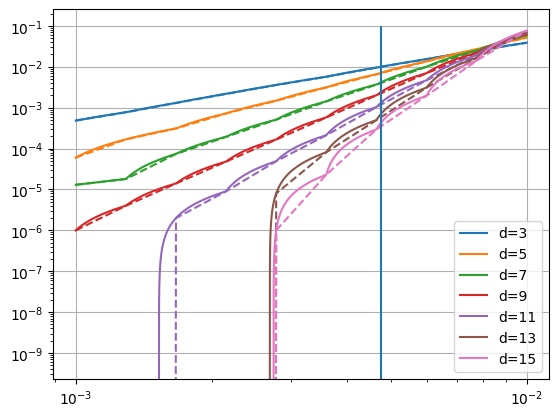

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mpc

for (distance, curve), color in zip(
    threshold_calculator.logical_errors_interpolated().items(), mpc.TABLEAU_COLORS
):
    plt.plot(
        threshold_calculator.fine_grained_physical_errors,
        curve,
        label=f"d={distance}",
        color=color,
    )
    plt.plot(
        physical_error_rates,
        logical_error_mean_curves_by_distance[distance],
        linestyle="--",
        color=color,
    )
plt.vlines(mu, 0, 0.1)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
# plt.xlim(0.0075, 0.01)
# plt.ylim(.005, .1)
plt.legend()
plt.show()

In [19]:
mu

0.008556886296139952

In [8]:
threshold_calculator.get_fitting_function(
    logical_errors=logical_error_mean_curves_by_distance[15]
)

In [9]:
distance_pairs = [(d1, d2) for d1, d2 in zip(
    code_distances[0:-1], code_distances[1:])]
logical_error_interpolated = threshold_calculator.logical_errors_interpolated()
threshold_guess = [
    threshold_calculator._approximate_crossover(
        logical_error_interpolated[_d2], logical_error_interpolated[_d1]
    )
    for _d1, _d2 in zip(code_distances[0:-1], code_distances[1:])
]

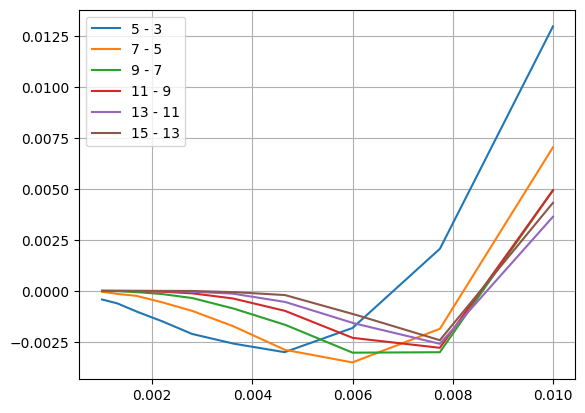

In [10]:
from scipy.interpolate import interp1d

interpolated_differences = []
for d1, d2 in zip(code_distances[0:-1], code_distances[1:]):
    interpolated_difference = interp1d(
        threshold_calculator.fine_grained_physical_errors,
        logical_error_interpolated[d2] - logical_error_interpolated[d1],
        fill_value="extrapolate",
    )
    interpolated_differences.append(interpolated_difference)

for entry, (d1, d2) in zip(interpolated_differences, distance_pairs):
    plt.plot(
        threshold_calculator.fine_grained_physical_errors,
        entry(threshold_calculator.fine_grained_physical_errors),
        label=f"{d2} - {d1}",
    )
plt.legend()
plt.grid()
plt.show()

In [11]:
threshold_guess

[0.0068192398257628534,
 0.008216695782125102,
 0.00859864259721138,
 0.008559665343734127,
 0.008684323279904305,
 0.00855410724854578]

In [17]:
for distance in code_distances:
    physical, logical = [
        *zip(
            *[
                (physical, logical)
                for physical, logical in zip(
                    physical_error_rates,
                    logical_error_mean_curves_by_distance[distance],
                )
                if logical > 0
            ]
        )
    ]
    print(distance)
    print(physical)
    print("\n")

3
(0.001, 0.001291549665014884, 0.0016681005372000592, 0.0021544346900318843, 0.0027825594022071257, 0.003593813663804626, 0.004641588833612777, 0.005994842503189409, 0.007742636826811269, 0.01)


5
(0.001, 0.001291549665014884, 0.0016681005372000592, 0.0021544346900318843, 0.0027825594022071257, 0.003593813663804626, 0.004641588833612777, 0.005994842503189409, 0.007742636826811269, 0.01)


7
(0.001, 0.001291549665014884, 0.0016681005372000592, 0.0021544346900318843, 0.0027825594022071257, 0.003593813663804626, 0.004641588833612777, 0.005994842503189409, 0.007742636826811269, 0.01)


9
(0.001, 0.001291549665014884, 0.0016681005372000592, 0.0021544346900318843, 0.0027825594022071257, 0.003593813663804626, 0.004641588833612777, 0.005994842503189409, 0.007742636826811269, 0.01)


11
(0.0016681005372000592, 0.0021544346900318843, 0.0027825594022071257, 0.003593813663804626, 0.004641588833612777, 0.005994842503189409, 0.007742636826811269, 0.01)


13
(0.0027825594022071257, 0.00359381366380